# The Forgotten Books:  Unseen Species Models and the Survival of Medieval Literature
## Supporting code 

The code in the present notebook relies on the `copia` software package (for Python 3.6+), which is available from [Github](https://github.com/mikekestemont/copia) and documented [here](https://copia.readthedocs.io/en/latest/). A recent version can be installed from PyPI (`>>> pip install copia`). In the cell below, we import the other modules on which the software depends:

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(543251) # control random seed

import copia.utils as u
from copia.richness import *
from copia.hill import hill_numbers
from copia.utils import survival_ratio
from copia.utils import evenness
from copia.plot import accumulation_curve
from copia.plot import multi_kde
from copia.plot import survival_errorbar
from copia.plot import evenness_plot
from copia.plot import density
from copia.plot import hill_plot

## Data

This repository ships with all datasets used in the study, which can be found as spreadsheets under `datasets/master`. We load the individual assemblages and convert them to `pandas` DataFrames:

In [2]:
lits = {}
for fn in sorted(glob.glob('../datasets/master/*.xlsx')):
    if 'anglo-norman' in fn:
        continue
    df = pd.read_excel(fn).dropna(subset = ["title"])
    lang = os.path.basename(fn).replace('.xlsx', '').lower()
    lits[lang] = df[['title', 'signature', 'repository']]

Next, we extract a high-number of high-level statistics from these datasets ($f_1$, $f_2$, $n$, and $S$, as well as the number of distinct repositories), which we cast to what is known as "abundance data" in ecology:

In [3]:
stats = []
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    s = u.basic_stats(abundance)
    d = {'language': lit}
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    d['repo'] = len(set(df['repository']))
    stats.append(d)

stats

[{'language': 'dutch', 'f1': 45, 'f2': 13, 'S': 75, 'n': 167, 'repo': 80},
 {'language': 'english', 'f1': 42, 'f2': 8, 'S': 69, 'n': 176, 'repo': 36},
 {'language': 'french', 'f1': 90, 'f2': 21, 'S': 222, 'n': 1473, 'repo': 234},
 {'language': 'german', 'f1': 36, 'f2': 19, 'S': 128, 'n': 1088, 'repo': 389},
 {'language': 'icelandic', 'f1': 44, 'f2': 28, 'S': 117, 'n': 295, 'repo': 12},
 {'language': 'irish', 'f1': 69, 'f2': 54, 'S': 188, 'n': 449, 'repo': 15}]

We add similar statistics for the union of the datasets, but do not include the number of repositories (because these have not been disambiguated across the assemblages):

In [4]:
stats_df = pd.DataFrame(stats)
stats_df['language'] = stats_df['language'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum()) + [None]
stats_df = stats_df.set_index('language')
stats_df

,f1,f2,S,n,repo
language,,,,,
dutch,45,13,75,167,80
english,42,8,69,176,36
french,90,21,222,1473,234
german,36,19,128,1088,389
icelandic,44,28,117,295,12
irish,69,54,188,449,15
all,326,143,799,3648,None


## Union

We start by analyzing the union of the six datasets. We explicitly add a language tag to each work's title, to avoid naming conflicts:

In [5]:
dfs = []
for lang, df in lits.items():
    df['title'] = [t+'_'+lang for t in df['title']]
    dfs.append(df)
    
df_all = pd.concat(dfs, ignore_index=True)
df_all

,title,signature,repository
0,Aiol (1)_dutch,"Leiden, UB, BPL 1049; Brussel, KB, IV 816","Leiden, UB ; Brussel, KB"
1,Aiol (2)_dutch,"Breda, Arch. Begijnhof, z.s.","Breda, Arch. Begijnhof"
2,Alexanders geesten_dutch,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek"
3,Alexanders geesten_dutch,"Gent, UB, 2749,6","Gent, UB"
4,Alexanders geesten_dutch,"Leiden, UB, Ltk. 1196","Leiden, UB"
...,...,...,...
3643,Lorgaireacht an tSoidhigh Naomhtha_irish,Royal Irish Academy (Dublin) D iv 2,"Royal Irish Academy, Dublin"
3644,Lorgaireacht an tSoidhigh Naomhtha_irish,Bodleian (Oxford) Rawlinson B 512,"Bodleian Library, Oxford"
3645,Stair na Lumbardach_irish,UCC Book of Lismore,"University College Library, Cork"
3646,[Seven Wise Masters]_irish,Trinity College Library MS 667,"Trinity College, Dublin"


We convert this information to abundance data, using a utility function from `copia`:

In [6]:
abundance = u.to_abundance(df_all['title'])

We'll store all resulting assets to an `outputs` directory:

In [7]:
try:
    os.mkdir('../outputs')
except FileExistsError:
    pass

First, we obtain point estimates for the survival of the numbers of works ("Chao1") and documents ("minsample"):

In [8]:
print('original # works:', diversity(abundance, method='chao1'))
print('original # documents:', diversity(abundance, method='minsample'))

original # works: 1170.492543092872
original # documents: 40614.31536631537


/Users/mikekestemont/GitRepos/copia/copia/richness.py:448: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


We continue with plotting density curves that show the bootstrap estimates (and associated quantiles) for the diversity estimates as survival ratios. Note that `survival_ratio()` converts the initial estimate to a survival rate, i.e. by taking the ratio of the estimates over the observed $S$ and $n$ respectively.

100%|██████████| 10000/10000 [00:01<00:00, 5127.51it/s]
/Users/mikekestemont/GitRepos/copia/copia/richness.py:448: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
100%|██████████| 10000/10000 [03:57<00:00, 42.18it/s]


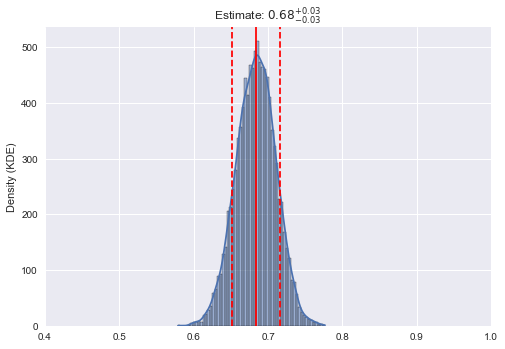

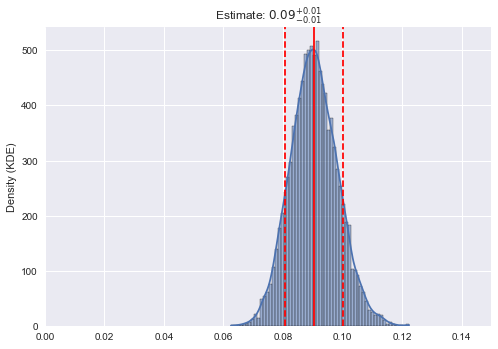

In [9]:
wsurvival_all = survival_ratio(abundance, method='chao1', n_iter=10000)
density(wsurvival_all, xlim=(0.4, 1));
plt.savefig('../outputs/dens_works.pdf')

dsurvival_all = survival_ratio(abundance, method='minsample', n_iter=10000)
density(dsurvival_all, xlim=(0, 0.15))
plt.savefig('../outputs/dens_docs.pdf')

Next, we plot the so-called **species accumulation curve** for the union of the datasets (which will take a while to run). This curve is relevant for specialists of medieval literature, as it gives an indication of the rate at which we might still be discovering new works in the future, by sighting more documents (provided these witnesses have yet not been lost beyond retrieval):

In [10]:
max_steps = 60000 # this number already takes into account the minsample-estimate
accumulation = species_accumulation(abundance, max_steps=max_steps)

100%|██████████| 100/100 [42:12<00:00, 25.33s/it]


To this plot, we will later add a kernel-density estimate that shows the bootstrapped estimates from the `minsample` estimate (on the secondary, horizontal axis). Informally, the resulting blob corresponds to the area where we expect the asymptotic curve from the previous to start saturating. During the `minsample`'s bootstrap procedure initiated in the cell below, `UserWarning`s may sporadically appear in cases where the optimization didn't satisfactorily converge. This is expected behavior.)

In [11]:
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True, n_iter=10000)

/Users/mikekestemont/GitRepos/copia/copia/richness.py:422: RuntimeWarning: overflow encountered in exp
  v = lambda x: np.exp(x * (2 * f2 / f1))
/Users/mikekestemont/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mikekestemont/GitRepos/copia/copia/richness.py:435: UserWarning: Tolerance criterion not met via fsolve: inf > 0.1-> backing off to grid-solver.
  warnings.warn(msg)
/Users/mikekestemont/GitRepos/copia/copia/richness.py:448: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


100%|██████████| 10000/10000 [03:56<00:00, 42.19it/s]


Finally, we plot the Hill number profile for the union of the datasets. We can do this both for the emprically observed data, as well as the bias-corrected reconstruction:

In [12]:
emp, est = hill_numbers(abundance, n_iter=10000)

100%|██████████| 10000/10000 [1:20:33<00:00,  2.07it/s]


We now combine the statistics calculated above into a single plot, where the species accumulation curve is plotted inside the Hill plot:

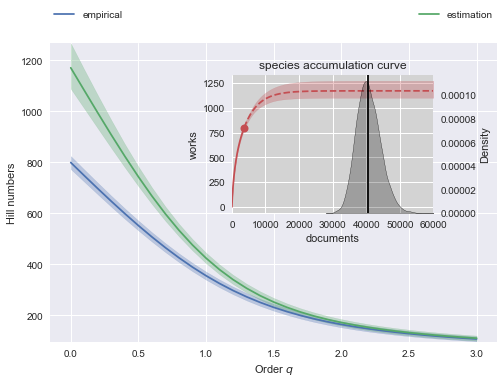

In [13]:
left, bottom, width, height = [0.44, 0.45, 0.35, 0.35]
fig, ax = plt.subplots()

hill_plot(emp, est, add_densities=False, ax=ax)
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_facecolor('lightgrey')

accumulation_curve(abundance, accumulation, c0='C2', c1='black',
                   xlabel='documents', ylabel='works',
                   title='species accumulation curve', ax=ax2,
                   minsample=minsample_est, xlim=(0, max_steps))

plt.savefig('../outputs/all_comb.pdf');

## Language-specific estimates

We now turn to the estimates for the individual vernaculars considered. We first convert the available counts data to abundance data:

In [14]:
assemblages = {}
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    assemblages[lit] = abundance

Point estimates for the original diversity of these assemblages are straightforward to obtain:

In [15]:
for category, assemblage in assemblages.items():
    print('category:', category)
    print('  - original # works:', diversity(assemblage, method='chao1'))
    print('  - original # documents:', diversity(assemblage, method='minsample'))

category: dutch
  - original # works: 152.41824044219254
  - original # documents: 2214.756047756048
category: english
  - original # works: 178.62357954545456
  - original # documents: 3620.006644006644
category: french
  - original # works: 414.72621472214144
  - original # documents: 27050.63947763948
category: german
  - original # works: 162.07391640866874
  - original # documents: 7483.8143958143955
category: icelandic
  - original # works: 151.4542372881356
  - original # documents: 1744.74944974945
category: irish
  - original # works: 231.98515219005196
  - original # documents: 2335.4753864753866


The survival ratios resulting from the bootstrap procedure can be calculated in the following way;

In [16]:
wsurvival = {}
for category, assemblage in assemblages.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1')

100%|██████████| 1000/1000 [00:01<00:00, 903.46it/s]


`copia` offers two auxiliary functions to visualize and compare the (bootstrapped) results across multiple assemblages. First, using colored kernel-density estimates:

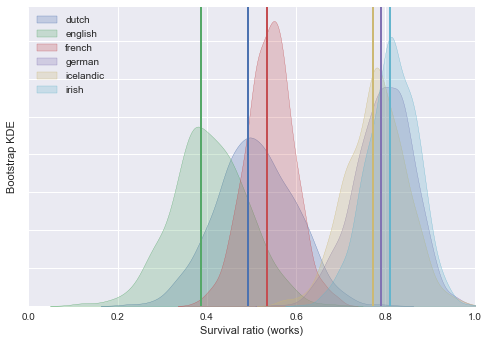

In [17]:
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_ylabel('Bootstrap KDE')
ax.set_yticklabels([])
plt.savefig('../outputs/survival_works_kde.pdf')

(Note how two clusters emerge.) Secondly, using error bars corresponding to the confidence intervals:

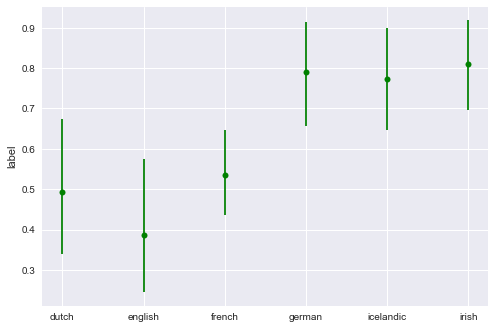

In [18]:
survival_errorbar(wsurvival)
plt.savefig('../outputs/survival_works_error.pdf')

The previous cells were for the survival ratios of works; those for documents can be calculated and plotted analogously. Relatively speaking, the results for documents mirror those for the works.

In [19]:
dsurvival = {}
for category, assemblage in assemblages.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')

100%|██████████| 1000/1000 [00:24<00:00, 40.18it/s]


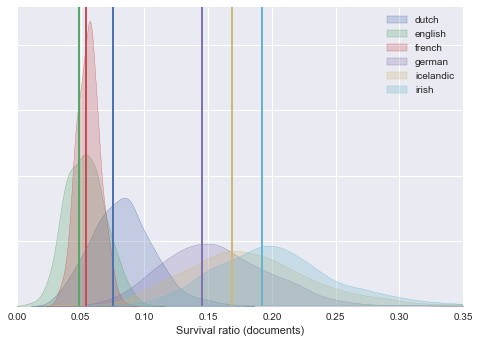

In [20]:
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.set_xlabel('Survival ratio (documents)')
plt.savefig('../outputs/survival_docs_kde.pdf')

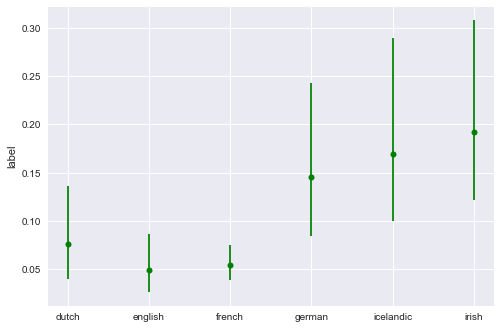

In [21]:
survival_errorbar(dsurvival)
plt.savefig('../outputs/survival_docs_error.pdf')

We can now summarize the results for the language-specific estimation into a single overview table:

In [22]:
for c in 'CH1 CH1-lCI CH1-uCI MS MS-lCI MS-uCI'.split():
    stats_df[c] = 0.0

# for individual languages:
for lang in wsurvival:
    stats_df.loc[lang, 'CH1'] = wsurvival[lang]['survival']
    stats_df.loc[lang, 'CH1-lCI'] = wsurvival[lang]['lci']
    stats_df.loc[lang, 'CH1-uCI'] = wsurvival[lang]['uci']

for lang in dsurvival:
    stats_df.loc[lang, 'MS'] = dsurvival[lang]['survival']
    stats_df.loc[lang, 'MS-lCI'] = dsurvival[lang]['lci']
    stats_df.loc[lang, 'MS-uCI'] = dsurvival[lang]['uci']
    
# for union:
stats_df.loc['all', 'CH1'] = wsurvival_all['survival']
stats_df.loc['all', 'CH1-lCI'] = wsurvival_all['lci']
stats_df.loc['all', 'CH1-uCI'] = wsurvival_all['uci']

stats_df.loc['all', 'MS'] = dsurvival_all['survival']
stats_df.loc['all', 'MS-lCI'] = dsurvival_all['lci']
stats_df.loc['all', 'MS-uCI'] = dsurvival_all['uci']

stats_df.round(3)

,f1,f2,S,n,repo,CH1,CH1-lCI,CH1-uCI,MS,MS-lCI,MS-uCI
language,,,,,,,,,,,
dutch,45,13,75,167,80,0.492,0.338,0.674,0.075,0.039,0.136
english,42,8,69,176,36,0.386,0.245,0.575,0.049,0.026,0.086
french,90,21,222,1473,234,0.535,0.437,0.648,0.054,0.039,0.075
german,36,19,128,1088,389,0.790,0.658,0.913,0.145,0.084,0.243
icelandic,44,28,117,295,12,0.773,0.648,0.899,0.169,0.100,0.290
irish,69,54,188,449,15,0.810,0.697,0.918,0.192,0.121,0.308
all,326,143,799,3648,None,0.683,0.631,0.734,0.090,0.076,0.107


The cell below dumps the result to a Latex table for inclusion in the paper:

In [23]:
with open('../outputs/results.txt', 'w') as f:
    f.write(stats_df.round(3).to_latex())

### Evenness

For plotting the evenness profiles, we first need to calculate the (estimated, reconstructed) Hill number profile for each of the languages:

In [24]:
hill_est = {}
for lang, assemblage in assemblages.items():
    _, est = hill_numbers(assemblage, n_iter=10000)
    hill_est[lang] = est

100%|██████████| 10000/10000 [04:28<00:00, 37.29it/s]


We can compute the (normalized) evenness profiles on the basis of the Hill number profiles:

In [25]:
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

Plotting these in a single graph can be done through calling the associated auxiliary function:

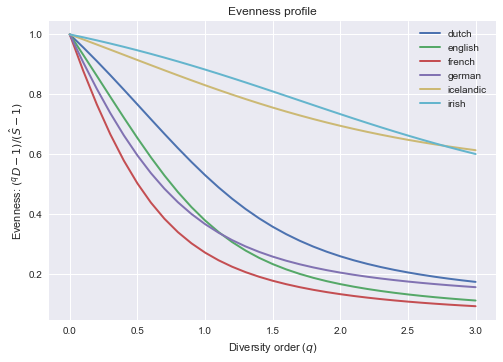

In [26]:
evenness_plot(evennesses)
plt.savefig('../outputs/evenness.pdf')

## Anglo-Norman

Because the scores for Middle English are so (extremely) low, it is worth investigating the ffect of complementing the English data with abundance data from Anglo-Norman literature. We can load this data, ignored above, as follows:

In [27]:
an_fn = '../datasets/master/anglo-norman.xlsx'
an = pd.read_excel(an_fn).dropna(subset = ["title"])
an = an[['title', 'signature']]
an

,title,signature
0,Romance of Horn,"Cambridge, CUL, Ff.vi.17"
1,Romance of Horn,"Cambridge, CUL, Add. 4407"
2,Romance of Horn,"Cambridge, CUL, Add. 4470"
3,Romance of Horn,"London, British Library, Harley 527"
4,Romance of Horn,"Oxford, Bodleian Library, Douce 132"
...,...,...
58,Gormont et Isembart,"Brussels, Bibl. Roy., portefeuille II.181"
59,La destructioun de Rome,"Hannover, Niedersachsische Landesbibl., IV.578"
60,La destructioun de Rome,"London, British Library, Egerton 3028"
61,Fierabras,"Hannover, Niedersachsische Landesbibl., IV.578"


In the cell below, we repeat some of the basic analyses above for the estimating the works diversity of the combined Middle English and Anglo-Norman data.

100%|██████████| 10000/10000 [00:01<00:00, 5027.30it/s]


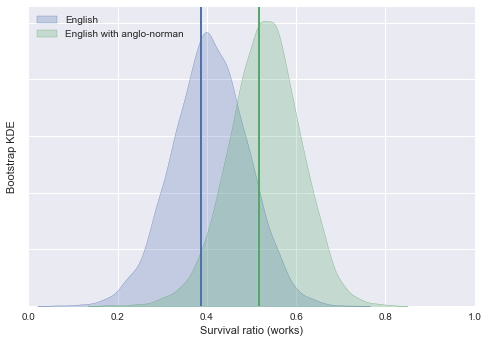

In [28]:
comp = {'English': assemblages['english'],
        'English with anglo-norman': np.concatenate((assemblages['english'],
                                                 u.to_abundance(an['title'])))
       }

wsurvival = {}
for category, assemblage in comp.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1', n_iter=10000)
    
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_ylabel('Bootstrap KDE')
ax.set_yticklabels([])

plt.savefig('../outputs/anglonorman.pdf');

In [29]:
for cat, res in wsurvival.items():
    print(f'{cat}: {round(res["survival"], 3)} [{round(res["lci"], 3)}-{round(res["uci"], 3)}]')

English: 0.386 [0.237-0.568]
English with anglo-norman: 0.516 [0.367-0.678]


## Additional estimators

In the paper, we focus on Chao1, which is an established and robust method in ecology. It is useful to compare the results, however, to a number of additional estimators for the work survival. From `copia`, the following alternatives are available:
- the higher-order **Jackknife**: a more general method for bias-correction in statistics
- **iChao1**: an variant of Chao1, that also takes into account $f_3$ and $f_4$
- the **Egghe & Proot** estimator, using the default setting of `alpha=150`.

In [30]:
comp = []

for estimator in ['chao1', 'jackknife', 'ichao1', 'egghe_proot']:
    for category, assemblage in assemblages.items():
        surv = survival_ratio(assemblage, method=estimator, n_iter=10000)
        comp.append([category, estimator, surv['survival'], surv['lci'], surv['uci']])
        
comp = pd.DataFrame(comp, columns=['tradition', 'estimator', 'survival', 'lci', 'uci'])

100%|██████████| 10000/10000 [00:01<00:00, 5485.03it/s]


In [31]:
estimates = comp.sort_values(['tradition', 'estimator'])
estimates

,tradition,estimator,survival,lci,uci
0,dutch,chao1,0.492067,0.332525,0.680841
18,dutch,egghe_proot,0.440399,0.278812,0.645471
12,dutch,ichao1,0.437208,0.293650,0.605953
6,dutch,jackknife,0.423729,0.331573,0.586830
1,english,chao1,0.386287,0.239041,0.570799
19,english,egghe_proot,0.318201,0.189128,0.491574
13,english,ichao1,0.366780,0.221661,0.565371
7,english,jackknife,0.338235,0.254306,0.504855
2,french,chao1,0.535293,0.435072,0.639999
20,french,egghe_proot,0.374413,0.287512,0.468024


In [32]:
with open('../outputs/other.txt', 'w') as f:
    f.write(estimates.round(3).to_latex())

We can visualize these results using a bar plot to obtain a better overview:

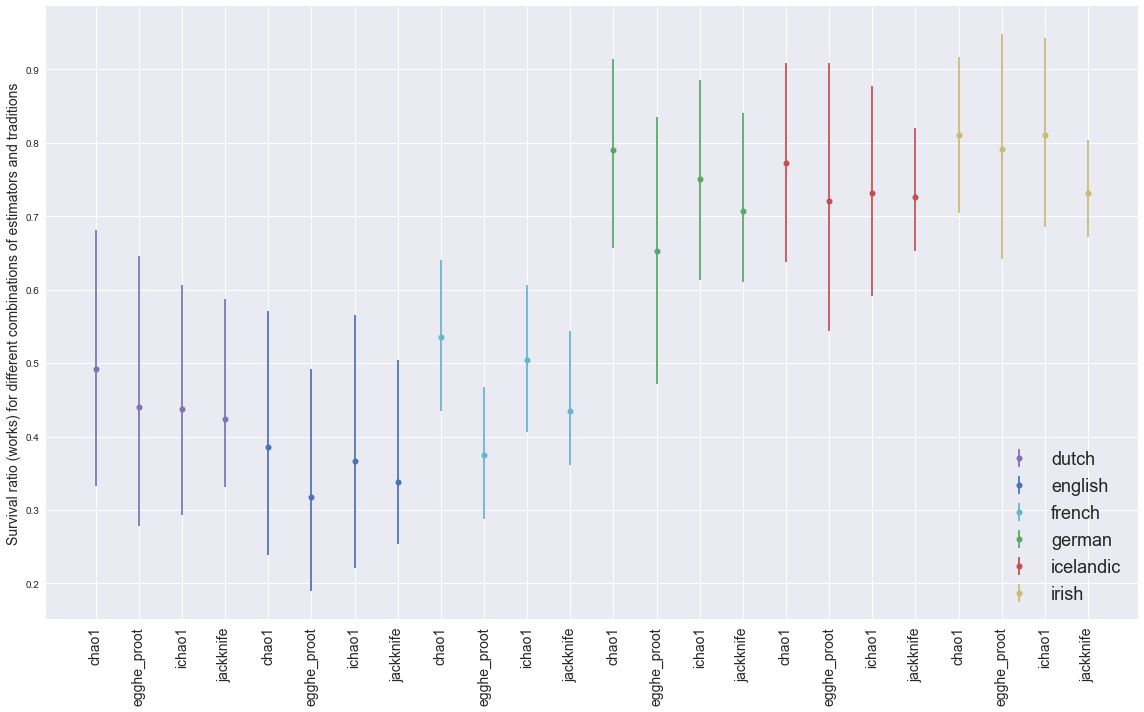

In [33]:
errors = np.array(list(zip(estimates['lci'], estimates['uci']))).T
errors[0] = estimates['survival'] - errors[0]
errors[1] -= estimates['survival']

fig, ax = plt.subplots(figsize=(16, 10))

traditions = tuple(set(estimates['tradition']))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(traditions)]
color_dict = dict(zip(traditions, colors))
labeled = {t:False for t in color_dict}

for idx in range(len(estimates)):
    trad = estimates['tradition'].iloc[idx]
    meth = estimates['estimator'].iloc[idx]
    if not labeled[trad]:
        c = color_dict[trad]
        labeled[trad] = True
        ax.errorbar(idx, estimates['survival'].iloc[idx],
            yerr=np.array([errors[:, idx]]).T,
            fmt='.', c=color_dict[trad], label=trad,
            ms=12)
    else:
        ax.errorbar(idx, estimates['survival'].iloc[idx],
            yerr=np.array([errors[:, idx]]).T,
            fmt='.', c=color_dict[trad], ms=12)


ax.set_ylabel('Survival ratio (works) for different combinations of estimators and traditions', fontsize=14)
ax.set_xticks(np.arange(len(estimates)))
ax.set_xticklabels(estimates['estimator'], rotation = 90, fontsize=14);
plt.legend(loc='lower right', fontsize=18)
plt.tight_layout()
plt.savefig('../outputs/other.pdf');

As can be seen, the methods show differences but are largely in agreement. The overall difference is confirmed, between the relatively lower survival rates for Dutch, English, and French, as opposed to the considerably higher survival rates for German, Icelandic and Irish.